## Imports/Setup

In [33]:
%run ../00_functions/00_custom_functions.ipynb
standard_setup(extra_packages=True, verbose=False)
data_ingestion_prep(start_yearmonth='1979-01', end_yearmonth='2022-12', verbose=False)

env: ESMFMKFILE=/home/ds4114/.conda/envs/leap_test202308-3/lib/esmf.mk
Files will be outputed as: .nc
ECMWF CDS API key already installed


## Collection: Sea Level Pressure (SLP)

#### ECMWF ERA5 SLP

In [10]:
#Sea level pressure comes from European Centre for Medium-Range Weather Forecasts (1940-01 to present only). It is the same source the one used for one SST above.
#More info can be found on https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=form
#We installed the API and have an account, so now we can download the ERA5 data via a loop (yearly)
slp_destination_folder = global_vars['download_folder']+r'SLP/originals/'    
for year in range(acquisition_start_year, acquisition_end_year+1, 1):
    slp_destination_filename = ''
    months = []
    if year == datetime.datetime.now().year:   #if a partial year; this prevents erorrs trying to use the API to get future/non-existant data    
        months = [i for i in range(1,datetime.datetime.now().month)]  
        slp_destination_filename = 'SLP_ECMWF_ERA5-monthly-reanalysis-MSLP_'+str(year)+'.nc'  #rename if desired for partial year
        #To consider, do we want to automatically overwrite parital years?
    else:
        slp_destination_filename = 'SLP_ECMWF_ERA5-monthly-reanalysis-MSLP_'+str(year)+'.nc'
        months = [i for i in range(1,12+1)]

    cdsapi_custom_download(year, months, 'mean_sea_level_pressure', slp_destination_folder, slp_destination_filename, overwrite=False, create_dest=False)
    
print("SLP Complete")

File SLP_ECMWF_ERA5-monthly-reanalysis-MSLP_1979.zarr already exists - (skipping download for 1979 )
File SLP_ECMWF_ERA5-monthly-reanalysis-MSLP_1980.zarr already exists - (skipping download for 1980 )
File SLP_ECMWF_ERA5-monthly-reanalysis-MSLP_1981.zarr already exists - (skipping download for 1981 )
File SLP_ECMWF_ERA5-monthly-reanalysis-MSLP_1982.zarr already exists - (skipping download for 1982 )
File SLP_ECMWF_ERA5-monthly-reanalysis-MSLP_1983.zarr already exists - (skipping download for 1983 )
File SLP_ECMWF_ERA5-monthly-reanalysis-MSLP_1984.zarr already exists - (skipping download for 1984 )
File SLP_ECMWF_ERA5-monthly-reanalysis-MSLP_1985.zarr already exists - (skipping download for 1985 )
File SLP_ECMWF_ERA5-monthly-reanalysis-MSLP_1986.zarr already exists - (skipping download for 1986 )
File SLP_ECMWF_ERA5-monthly-reanalysis-MSLP_1987.zarr already exists - (skipping download for 1987 )
File SLP_ECMWF_ERA5-monthly-reanalysis-MSLP_1988.zarr already exists - (skipping download f

2023-08-28 14:17:03,589 INFO Welcome to the CDS
2023-08-28 14:17:03,590 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-08-28 14:17:03,872 INFO Request is queued
2023-08-28 14:17:05,001 INFO Request is running
2023-08-28 14:17:09,007 INFO Request is completed
2023-08-28 14:17:09,008 INFO Downloading https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data0/adaptor.mars.internal-1693232226.317367-24424-14-4c867e63-351c-4317-a25c-dd04cef54d3f.nc to ../tmp/SLP_ECMWF_ERA5-monthly-reanalysis-MSLP_2023.nc (27.7M)
2023-08-28 14:17:12,281 INFO Download rate 8.5M/s   


Transferring to GS gs://leap-persistent/ds4114/online_data/SLP/originals/SLP_ECMWF_ERA5-monthly-reanalysis-MSLP_2023.zarr...
SLP Complete


## Processing: Sea Level Pressure (SLP)

#### ECMWF ERA5 SLP

In [71]:
mslp = xr_open_mfdataset_custom(global_vars['download_folder']+r'SLP/originals/SLP_ECMWF_ERA5-monthly-reanalysis-MSLP_*.nc') 

In [72]:
%%time
#Regrid slp
mslp_highres = mslp.sel(expver=1).msl/100  #do do not need the experimental/recent data because socat is only up till end of the prior yer. Also Pa to HPa. 
    #Note the expver variable indicates new experimental data: #https://confluence.ecmwf.int/pages/viewpage.action?pageId=173385064
    #Data in recent 3 months will be blank with expver = 1 but this is expected and filtered next
mslp_highres = mslp_highres.sel(time=slice(str(processed_start_yearmonth),str(processed_end_yearmonth))) #already monthly so select desired years
mslp_highres = xr.Dataset({'mslp':(['time','latitude','longitude'],mslp_highres.data),'time':(['time'],mslp_highres.time.data),'latitude':(['latitude'],mslp_highres.latitude.data),'longitude':(['longitude'],mslp_highres.longitude.data)})
mslp_highres_regridder = xesmf.Regridder(mslp_highres, ideal_grid, 'bilinear', periodic=True) #See note above about bilinear vs conservative
mslp_out = mslp_highres_regridder(mslp_highres.chunk(-1), keep_attrs=False)
#mslp_out

CPU times: user 11.9 s, sys: 513 ms, total: 12.4 s
Wall time: 12.4 s


In [73]:
mslp_out = mslp_out.rename({'latitude': 'ylat','longitude': 'xlon'}) #rename to be consistent with prior work
mslp_out = mslp_out.assign_coords(time=ttime) #overwrite time dimension to be midmonth
mslp_out.mslp.attrs['units'] = 'hPa'

In [75]:
output_xarray_with_date(mslp_out, global_vars['download_folder']+'SLP/processed/', 'SLP_ECMWF_ERA5-monthly-reanalysis-1x1-MSLP', output_file_type)

Cancelling output - SLP_ECMWF_ERA5-monthly-reanalysis-1x1-MSLP_198201-202304.nc already exists in /data/artemis/workspace/ds4114/online_data/SLP/processed/


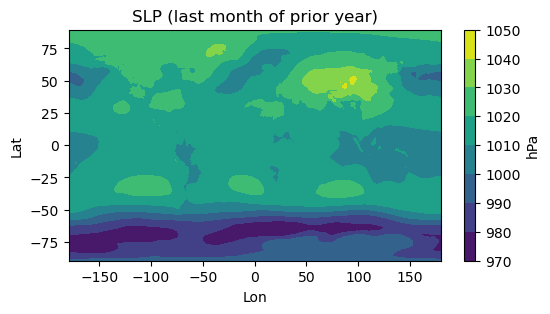

In [74]:
fig = plt.figure(figsize=(figsizew,figsizeh))
plt.contourf(ideal_grid.longitude,ideal_grid.latitude,mslp_out.mslp.sel(time='2022-12-15').data) #just choosing one month from prior year
plt.title('SLP (last month of prior year)'); plt.xlabel('Lon'); plt.ylabel('Lat')
plt.colorbar().set_label('hPa');